In [2]:
import torch
import torch.nn as nn
import numpy as np
import math
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader

## Setting the Hyperparameters

In [45]:
batch_size = 400
max_seq_len = 45
input_dim = 512
d_model = 512
num_heads = 8
ffn_hidden = 2048
num_layers = 6
dropout_rate = 0.1
learning_rate = 0.0001
num_epochs = 10
top = 1000000

In [4]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Multihead Self Attention

In [5]:
def scaled_dot_product_attention(q,k,v,mask=None):
    d_k = q.size(-1)
    qk = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
        qk = qk.permute(1, 0, 2, 3) + mask
        qk = qk.permute(1, 0, 2, 3)
    qk = F.softmax(qk, dim=-1)
    new_qkv = torch.matmul(qk, v)
    return new_qkv

class Multihead_Self_Attention(nn.Module):
    def __init__(self,input_dim, d_model, num_heads):
        super(Multihead_Self_Attention, self).__init__()
        self.input_dim = input_dim
        self.model_dim = d_model
        self.num_heads = num_heads
        self.head_dim = self.model_dim // self.num_heads
        self.qkv_layer = nn.Linear(input_dim, 3 * self.model_dim)
        self.concat_layer = nn.Linear(self.model_dim, self.model_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self,x,mask=None):
        qkv = self.qkv_layer(x)
        a,b,c = qkv.size()
        qkv = qkv.view(batch_size,max_seq_len,self.num_heads,3*self.head_dim)
        qkv = qkv.permute(0,2,1,3)
        q,k,v = qkv.chunk(3,dim=-1)
        new_qkv = scaled_dot_product_attention(q,k,v,mask)
        new_qkv = new_qkv.permute(0,2,1,3)
        new_qkv = new_qkv.reshape(batch_size,max_seq_len,self.model_dim)
        out = self.concat_layer(new_qkv)
        return out

## Multihead Cross Attention

In [6]:
class Multihead_Cross_Attention(nn.Module):
    def __init__(self,input_dim, model_dim, num_heads):
        super(Multihead_Cross_Attention, self).__init__()
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads
        self.qk_layer = nn.Linear(input_dim, 2 * model_dim)
        self.v_layer = nn.Linear(input_dim, model_dim)
        self.concat_layer = nn.Linear(model_dim, model_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self,x,y,mask=None):
        qk = self.qk_layer(x)
        v = self.v_layer(y)
        qk = qk.view(batch_size,max_seq_len,num_heads,2*self.head_dim)
        v = v.view(batch_size,max_seq_len,num_heads,self.head_dim)
        qk = qk.permute(0,2,1,3)
        v = v.permute(0,2,1,3)
        q,k = qk.chunk(2,dim=-1)
        new_qkv = scaled_dot_product_attention(q,k,v,mask)
        new_qkv = new_qkv.permute(0,2,1,3)
        new_qkv = new_qkv.reshape(batch_size,max_seq_len,self.model_dim)
        out = self.concat_layer(new_qkv)
        return out

## Positional Encoding

In [7]:
class PostionalEncoding(nn.Module):
    def __init__(self,max_seq_len,d_model):
        super(PostionalEncoding,self).__init__()
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        self.encoding = torch.zeros(self.max_seq_len,self.d_model)

    def forward(self,x):
        even_index = torch.arange(0,self.d_model,2).float()
        domenator = torch.pow(10000,even_index/self.d_model)
        position = torch.arange(0,self.max_seq_len).unsqueeze(1)
        PE_even = torch.sin(position/domenator)
        PE_odd = torch.cos(position/domenator)
        stacked = torch.stack([PE_even,PE_odd],dim=2)
        PE_flatten = torch.flatten(stacked,start_dim=1,end_dim=2)
        return PE_flatten

## Normalization Layer

In [8]:
class NormalizationLayer(nn.Module):
    def __init__(self, parameter_dim):
        super(NormalizationLayer, self).__init__()
        self.parameters_shape = parameter_dim
        self.gamma = nn.Parameter(torch.ones(parameter_dim))
        self.beta = nn.Parameter(torch.zeros(parameter_dim))
        self.eps = 1e-6

    def forward(self, x):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = x.mean(dims, keepdim=True)
        std = x.std(dims, keepdim=True)
        out = self.gamma * (x - mean) / (std + self.eps) + self.beta
        return out

## Position-wise Feed-Forward

In [9]:
class FeedForward(nn.Module):
    def __init__(self,d_model,ffn_hidden):
        super(FeedForward,self).__init__()
        self.d_model = d_model
        self.ffn_hidden = ffn_hidden
        self.layer1 = nn.Linear(self.d_model,self.ffn_hidden)
        self.layer2 = nn.Linear(self.ffn_hidden,self.d_model)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self,x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x

## Encoder

In [10]:
class Encoder_Layer(nn.Module):
    def __init__(self,num_heads, d_model, ffn_hidden, max_seq_len, dropout_rate):
        super(Encoder_Layer,self).__init__()
        self.multihead_attention = Multihead_Self_Attention(input_dim,d_model,num_heads)
        self.pos_encoding = PostionalEncoding(max_seq_len,d_model)
        self.feedforward = FeedForward(d_model,ffn_hidden)
        self.norm1 = NormalizationLayer([d_model])
        self.norm2 = NormalizationLayer([d_model])
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self,x,mask=None):
        reseduial_x = x
        x = self.multihead_attention(x,mask)
        x = self.dropout1(x)
        x = x + reseduial_x
        x = self.norm1(x)
        reseduial_x = x
        x = self.feedforward(x)
        x = self.dropout2(x)
        x = x + reseduial_x
        x = self.norm2(x)
        return x

In [11]:
class SequentialEncoder(nn.Sequential):
    def forward(self, *inputs):
        x, self_attention_mask  = inputs
        for module in self._modules.values():
            x = module(x, self_attention_mask)
        return x

In [12]:

class Encoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, dropout_rate, num_layers,max_seq_len):
        super().__init__()
        self.layers = SequentialEncoder(*[Encoder_Layer(num_heads, d_model, ffn_hidden, max_seq_len, dropout_rate)
                                     for _ in range(num_layers)])
    def forward(self, x, mask=None):
        x = self.layers(x, mask)
        return x

## Decoder

In [13]:
class Decoder_Layer(nn.Module):
    def __init__(self,num_heads, d_model, ffn_hidden, max_seq_len, dropout_rate):
        super(Decoder_Layer,self).__init__()
        self.multihead_self_attention = Multihead_Self_Attention(input_dim,d_model,num_heads)
        self.multihead_cross_attention = Multihead_Cross_Attention(input_dim,d_model,num_heads)
        self.feedforward = FeedForward(d_model,ffn_hidden)
        self.norm1 = NormalizationLayer([d_model])
        self.norm2 = NormalizationLayer([d_model])
        self.norm3 = NormalizationLayer([d_model])
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)

    def forward(self, x, y, self_attention_mask=None, cross_attention_mask=None):
        reseduial_y = y
        y = self.multihead_self_attention(y,mask = self_attention_mask)
        y = self.dropout1(y)
        y = y + reseduial_y
        y = self.norm1(y)

        reseduial_y = y
        y = self.multihead_cross_attention(x,y,mask = cross_attention_mask)
        y = self.dropout2(y)
        y = y + reseduial_y
        y = self.norm2(y)

        reseduial_y = y
        y = self.feedforward(y)
        y = self.dropout3(y)
        y = y + reseduial_y
        y = self.norm3(y)

        return y

In [14]:
class Sequential_Decoder(nn.Sequential):
    def forward(self,*input):
        x, y, self_attention_mask, cross_attention_mask = input
        for module in self._modules.values():
            y = module(x, y, self_attention_mask, cross_attention_mask)
        return y

In [15]:
class Decoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, dropout_rate, num_layers,max_seq_len):
        super().__init__()
        self.layers = Sequential_Decoder(*[Decoder_Layer(num_heads, d_model, ffn_hidden, max_seq_len, dropout_rate)
                                     for _ in range(num_layers)])
    def forward(self, x, y,self_attention_mask=None, cross_attention_mask=None):
        y = self.layers(x, y,self_attention_mask, cross_attention_mask)
        return y

In [23]:
NEG_INFTY = -1e9

def create_masks(eng_batch, ar_batch):
    num_sentences = len(eng_batch)
    look_ahead_mask = torch.full([max_seq_len, max_seq_len] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.full([num_sentences, max_seq_len, max_seq_len] , False)
    decoder_padding_mask_self_attention = torch.full([num_sentences, max_seq_len, max_seq_len] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, max_seq_len, max_seq_len] , False)

    for idx in range(num_sentences):
      eng_sentence_length, ar_sentence_length = len(eng_batch[idx]), len(ar_batch[idx])
      eng_chars_to_padding_mask = np.arange(eng_sentence_length + 1, max_seq_len)
      ar_chars_to_padding_mask = np.arange(ar_sentence_length + 1, max_seq_len)
      encoder_padding_mask[idx, :, eng_chars_to_padding_mask] = True
      encoder_padding_mask[idx, eng_chars_to_padding_mask, :] = True
      decoder_padding_mask_self_attention[idx, :, ar_chars_to_padding_mask] = True
      decoder_padding_mask_self_attention[idx, ar_chars_to_padding_mask, :] = True
      decoder_padding_mask_cross_attention[idx, :, eng_chars_to_padding_mask] = True
      decoder_padding_mask_cross_attention[idx, ar_chars_to_padding_mask, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)

    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

## Transformer

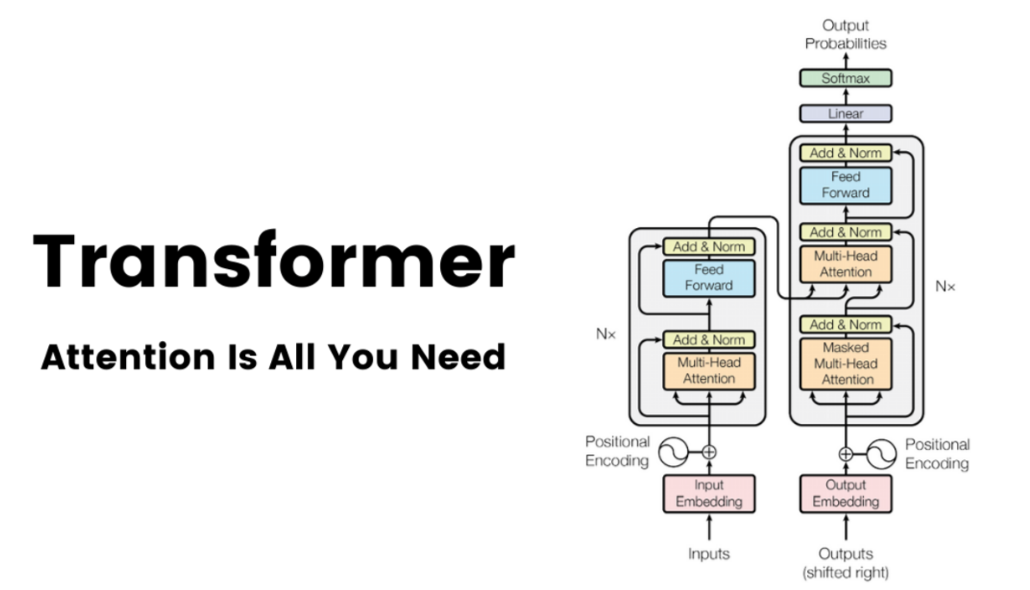

In [39]:
class Transformer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, dropout_rate, num_layers,
                max_seq_len, ar_vocab_size, english_to_index, arabic_to_index,
                START_TOKEN, END_TOKEN, PADDING_TOKEN
                ):
        super().__init__()
        self.enc_sentence_embedding = SentenceEmbedding(english_to_index, max_seq_len, d_model,START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.encoder = Encoder(d_model, ffn_hidden, num_heads, dropout_rate, num_layers, max_seq_len)

        self.dec_sentence_embedding = SentenceEmbedding(arabic_to_index, max_seq_len, d_model,START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, dropout_rate, num_layers, max_seq_len)

        self.linear = nn.Linear(d_model, ar_vocab_size)
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def forward(self, x, y, enc_start_token=False, enc_end_token=False, dec_start_token=True, dec_end_token=True):

        encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(x, y)
        encoder_self_attention_mask = encoder_self_attention_mask.to(self.device)
        decoder_self_attention_mask = decoder_self_attention_mask.to(self.device)
        decoder_cross_attention_mask = decoder_cross_attention_mask.to(self.device)

        x = self.enc_sentence_embedding(x, start_token=enc_start_token, end_token=enc_end_token)
        x = self.encoder(x, encoder_self_attention_mask)

        y = self.dec_sentence_embedding(y, start_token=dec_start_token, end_token=dec_end_token)
        out = self.decoder(x, y, decoder_self_attention_mask, decoder_cross_attention_mask)
        out = self.linear(out)
        return out

In [40]:
train_loader = DataLoader(dataset, batch_size)
iterator = iter(train_loader)

In [41]:
for batch_num, batch in enumerate(iterator):
    print(batch)
    if batch_num > 3:
        break

[('and this', 'it was um', 'what is she doing here', 'i dont like it', ' its none of your business', ' uhhuh', ' others', 'im much your majesty', 'do i make myself clear', 'thank you', 'i bet you do', 'thats enough', 'yeah of course', 'im him', 'you okay', 'no no', 'shes all yours', 'you want the truth', 'how about you', ' goodbye', ' thats okay', 'im sorry', 'i must go', 'maybe we have something in common', 'right alright alright relax', ' have a seat', 'hows it goin', ' are you all right', 'whats up', ' what did you do', 'what happened', 'is this all youve got', ' that right', 'as in mother id like to fuck', ' ooh ooh ooh honey', 'what is your name', 'what was that', 'smells good', 'from what', 'it wasnt easy', 'and you', 'i dont think so', 'just take your time', ' over here', 'hell no', 'excuse me', 'what are you waiting for', 'like you', ' thats sad', 'what are you doing here', ' all right', 'how about everyone out here', 'i agree', 'number three', 'what was that you said', 'killia

## Training

In [42]:
transformer = Transformer(d_model, ffn_hidden,num_heads, dropout_rate, num_layers, max_seq_len,len(index_to_arabic),english_to_index,arabic_to_index,
                          START_TOKEN, END_TOKEN, PADDING_TOKEN)

In [43]:
criterian = nn.CrossEntropyLoss(ignore_index = arabic_to_index[PADDING_TOKEN], reduction='none')

for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)

optim = torch.optim.Adam(transformer.parameters(), lr=learning_rate)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [44]:
transformer.train()
transformer.to(device)
total_loss = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    iterator = iter(train_loader)
    print(len(iterator))
    for batch_num, batch in enumerate(iterator):
        transformer.train()
        eng_batch, ar_batch = batch
        optim.zero_grad()
        if(len(ar_batch)!=batch_size): break
        ar_predictions = transformer(eng_batch,ar_batch)
        labels = transformer.dec_sentence_embedding.batch_tokenize(ar_batch, start_token=False, end_token=True)
        loss = criterian(
            ar_predictions.view(-1, len(arabic_voc)).to(device),
            labels.view(-1).to(device)
        ).to(device)
        valid_indicies = torch.where(labels.view(-1) == arabic_to_index[PADDING_TOKEN], False, True)
        loss = loss.sum() / valid_indicies.sum()
        loss.backward()
        optim.step()
        #train_losses.append(loss.item())
        if batch_num % 100 == 0:
            print(f"Iteration num: {batch_num} , training loss: {loss.item()}")
            print(f"English: {eng_batch[0]}")
            print(f"Arabic Translation: {ar_batch[0]}")
            ar_sentence_predicted = torch.argmax(ar_predictions[0], axis=1)
            predicted_sentence = ""
            for idx in ar_sentence_predicted:
              if idx == arabic_to_index[END_TOKEN]:
                break
              predicted_sentence += index_to_arabic[idx.item()]
            print(f"Arabic Prediction: {predicted_sentence}")

            transformer.eval()


Epoch 0
1369
Iteration num: 0 , training loss: 6.036006450653076
English: and this
Arabic Translation: و هذه؟
Arabic Prediction: ۀۀۀۀۀۀۀۀۀ~ۀۀۀۀۀۀۀۀۀۀۀۀۀۀۀۀۀۀۀۀۀۀۀۀۀۀۀ٤ۀس*ۋس~ۀ
Iteration num: 100 , training loss: 3.305302381515503
English: you gotta keep going
Arabic Translation: عليك أن تستمر بالهرب
Arabic Prediction:        ا ل  ل  ل                        ا  ا 
Iteration num: 200 , training loss: 3.289287805557251
English: i did
Arabic Translation: نعم فعلت
Arabic Prediction:                      اا     ا  ا             
Iteration num: 300 , training loss: 3.3027591705322266
English: its here its here
Arabic Translation: "إنها هنا، إنها هنا"
Arabic Prediction:    ا     ا         ا             ا    ا   ا  
Iteration num: 400 , training loss: 3.1072630882263184
English: garrett was a madman
Arabic Translation: "غاريت" كان مجنونا
Arabic Prediction:       ا       ا ا
Iteration num: 500 , training loss: 3.0382425785064697
English:  youre sorry
Arabic Translation: -أنت آسف؟
Arabic Predictio

In [ ]:
transformer.train()
transformer.to(device)
total_loss = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    iterator = iter(train_loader)
    print(len(iterator))
    for batch_num, batch in enumerate(iterator):
        transformer.train()
        eng_batch, ar_batch = batch
        optim.zero_grad()
        if(len(ar_batch)!=batch_size): break
        ar_predictions = transformer(eng_batch,ar_batch)
        labels = transformer.dec_sentence_embedding.batch_tokenize(ar_batch, start_token=False, end_token=True)
        loss = criterian(
            ar_predictions.view(-1, len(arabic_voc)).to(device),
            labels.view(-1).to(device)
        ).to(device)
        valid_indicies = torch.where(labels.view(-1) == arabic_to_index[PADDING_TOKEN], False, True)
        loss = loss.sum() / valid_indicies.sum()
        loss.backward()
        optim.step()
        #train_losses.append(loss.item())
        if batch_num % 100 == 0:
            print(f"Iteration num: {batch_num} , training loss: {loss.item()}")
            print(f"English: {eng_batch[0]}")
            print(f"Arabic Translation: {ar_batch[0]}")
            ar_sentence_predicted = torch.argmax(ar_predictions[0], axis=1)
            predicted_sentence = ""
            for idx in ar_sentence_predicted:
              if idx == arabic_to_index[END_TOKEN]:
                break
              predicted_sentence += index_to_arabic[idx.item()]
            print(f"Arabic Prediction: {predicted_sentence}")

            transformer.eval()


Epoch 0
1369
Iteration num: 0 , training loss: 1.03951096534729
English: and this
Arabic Translation: و هذه؟
Arabic Prediction: و هذها
Iteration num: 100 , training loss: 0.8189812302589417
English: you gotta keep going
Arabic Translation: عليك أن تستمر بالهرب
Arabic Prediction: علكك أن تتتار بالجرب
Iteration num: 200 , training loss: 0.7353418469429016
English: i did
Arabic Translation: نعم فعلت
Arabic Prediction: نعم ف
Iteration num: 300 , training loss: 0.7282065153121948
English: its here its here
Arabic Translation: "إنها هنا، إنها هنا"
Arabic Prediction: .إنها هنا، إنهذ هل  اهه-ههاهههههمههه-هههههههه
Iteration num: 400 , training loss: 0.6034501194953918
English: garrett was a madman
Arabic Translation: "غاريت" كان مجنونا
Arabic Prediction: "حاريت" كان مجنونا
Iteration num: 500 , training loss: 0.6089304089546204
English:  youre sorry
Arabic Translation: -أنت آسف؟
Arabic Prediction: -أنا آسف؟
Iteration num: 600 , training loss: 0.5646094083786011
English: what is he after
Arabic T